# Script de modélisation

## Prise en compte des données

In [1]:
import pandas as pd
import numpy as np
import panel as pn

%matplotlib inline
import matplotlib.pyplot as plt

data = pd.read_csv('result_requetes.csv')
#data.head()

In [2]:
#len(data)

In [3]:
#data.dtypes

In [4]:
#On affecte le bon type aux variables qualitatives
data["city"]=pd.Categorical(data["city"],ordered=False)
data["language"]=pd.Categorical(data["language"],ordered=False)
data["group"]=pd.Categorical(data["group"],ordered=False)
data["brand"]=pd.Categorical(data["brand"],ordered=False)

data["mobile"]=pd.Categorical(data["mobile"],ordered=False)
data["parking"]=pd.Categorical(data["parking"],ordered=False)
data["pool"]=pd.Categorical(data["pool"],ordered=False)
data["children_policy"]=pd.Categorical(data["children_policy"],ordered=False)

data["hotel_id"]=pd.Categorical(data["hotel_id"],ordered=False)
data["avatar_id"]=pd.Categorical(data["avatar_id"],ordered=False)

data["price"]=pd.DataFrame(data["price"], dtype=float)

#data.dtypes
#data.head()

## Analyse de données -> Fichier analyse

## Extraction des échantillons d'apprentissage et de validation

In [5]:
#data.head()

### Xtrain avec conversion des variables catégorielles en dummy/indicator variables

Utilisation de OneHotEncoder au lieu de pd.get_dummies

In [6]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()  
#scaler.fit(X_train)  
#Xr_train = scaler.transform(X_train)  
# Meme transformation sur le test
#Xr_val = scaler.transform(X_val)

In [7]:
from sklearn.preprocessing import OneHotEncoder
#avec l'hotel_id
X=data[["city","language","mobile","hotel_id","group","brand","parking","pool","children_policy"]]
#sans l'hotel_id
#X=data[["city","language","mobile","group","brand","parking","pool","children_policy"]]
enc = OneHotEncoder()
enc.fit(X)
#enc.categories_

OneHotEncoder()

In [8]:
Xenc=enc.transform(X).toarray()
#Xenc

In [9]:
dataDum=pd.DataFrame(Xenc)
#dataDum

In [10]:
dataQuant = data[["stock","date","nb_requete"]]
#dataDum = pd.get_dummies(data[["city","language","mobile","hotel_id","group","brand","parking","pool","children_policy"]])
dfC = pd.concat([dataQuant,dataDum],axis=1)
#dfC.head()

In [11]:
Y = data[["price"]]
#Y.head()

In [12]:
#len(Xtrain)
#dfC.shape

In [13]:
#len(Y)

In [14]:
from sklearn.model_selection import train_test_split  
#test_size = échantillon test de taille ... parmi les ... observations (20 %)
#longueur = int(0.2*len(Y))
X_train,X_val,Y_train,Y_val=train_test_split(dfC,Y,test_size=0.2,random_state=11)

In [15]:
#print(X_train.shape,len(Y_train))

In [16]:
#X_train

In [17]:
Ytrain = np.ravel(Y_train)
#Ytrain

### Standardisation des données?
Inutile pour RandomForest / utile pour XGBoost?

Si oui à faire sur l'échantillon test du Defi

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.transform(X_train)  
# Meme transformation sur le test
Xr_val = scaler.transform(X_val)

## Modélisation avec une forêt aléatoire

In [19]:
#help(RandomForestRegressor)
#help(forest.fit)

Premier modèle avec 100 arbres dans la forêt et 2 variables tirées aléatoirement lors de la construction de chq noeud.

In [20]:
from sklearn.ensemble import RandomForestRegressor
# définition des paramètres
forest = RandomForestRegressor(n_estimators=100, 
   criterion='mse', max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features='auto', max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(Xr_train,Ytrain)
forest.score(Xr_train,Ytrain)

0.9995756954909796

In [21]:
forest.score(Xr_val,Y_val)

0.9973142844246274

MSE et R2 score sur l'échantillon de validation :

In [ ]:
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score
#prev=rfFit.predict(X_val)
#print("MSE=",mean_squared_error(Y_val,prev))
#print("R2=",r2_score(Y_val,prev))

Comparaison graphique entre prix prédit par le modèle et prix exact

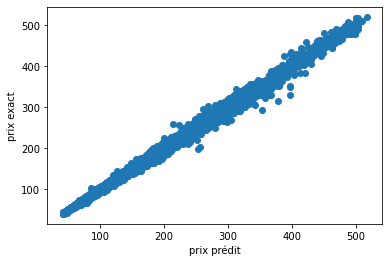

In [22]:
prev=rfFit.predict(Xr_val)
plt.plot(prev,Y_val,"o")
plt.xlabel(u"prix prédit")
plt.ylabel(u"prix exact")
plt.show()

Graphique des résidus entre prix prédit par le modèle et prix exact

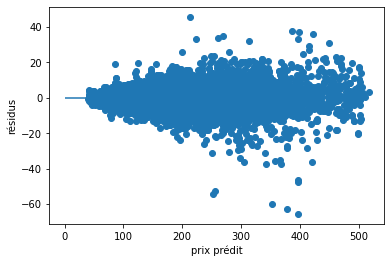

In [23]:
plt.plot(prev,np.ravel(Y_val) - prev,"o")
plt.xlabel(u"prix prédit")
plt.ylabel(u"résidus")
plt.hlines(0,0,500)
plt.show()

Indices d'importance - difficile à interpréter ici

In [ ]:
#rf= RandomForestRegressor(n_estimators=100,max_features=2)
#rfFit=rf.fit(X_train, Ytrain)
# Importance décroissante des variables
#importances = rfFit.feature_importances_
#indices = np.argsort(importances)[::-1]
#for f in range(X_train.shape[1]):
#    print(dfC.columns[indices[f]], importances[indices[f]])

In [ ]:
# Graphe des importances
#plt.figure()
#plt.title("Importances des variables")
#plt.bar(range(X_train.shape[1]), importances[indices])
#plt.xticks(range(X_train.shape[1]), indices)
#plt.xlim([-1, X_train.shape[1]])
#plt.show()

Optimisation par validation croisée du nombre d'arbres dans la forêts et du nombre de variables tirées aléatoirement lors de la construction de chaque noeud. RESULTAT MOINS BON ?!

UTILISER DE LA VALIDATION CROISEE MC !!!

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param=[{"n_estimators":list(range(100,300,100)),"max_features":list(range(2,4,1))}]
forestOpt = GridSearchCV(RandomForestRegressor(),
        param,cv=5,n_jobs=-1)
rfOpt=forestOpt.fit(Xr_train, Ytrain)
print("Meilleur score = %f, Meilleur paramètre = %s" % (rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.968945, Meilleur paramètre = {'max_features': 3, 'n_estimators': 200}


In [20]:
forestOpt.score(Xr_train,Ytrain)

0.9960557884344526

In [21]:
forestOpt.score(Xr_val,Y_val)

0.97212249924179

In [ ]:
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score
#prev2=rfOpt.predict(X_val)
#print("MSE=",mean_squared_error(Y_val,prev))
#print("R2=",r2_score(Y_val,prev))

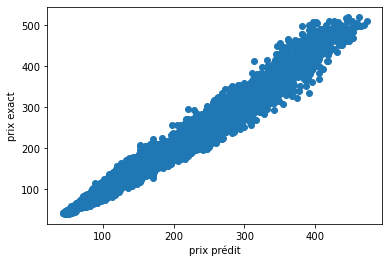

In [31]:
prevOpt=rfOpt.predict(Xr_val)
plt.plot(prevOpt,Y_val,"o")
plt.xlabel(u"prix prédit")
plt.ylabel(u"prix exact")
plt.show()

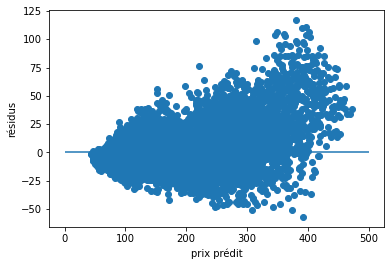

In [35]:
plt.plot(prevOpt,np.ravel(Y_val) - prevOpt,"o")
plt.xlabel(u"prix prédit")
plt.ylabel(u"résidus")
plt.hlines(0,0,500)
plt.show()

In [ ]:
#prev0=np.around(prev, decimals=1)
#prev0

In [ ]:
#len(prev0)
#indice0 = pd.DataFrame(np.arange(0,len(prev0)),columns = ['index'])
#indice0

In [ ]:
#price0=pd.DataFrame(prev0,columns = ['price'])
#price0

In [ ]:
#sub0=indice0.join(price0, on=None, how='right', lsuffix='', rsuffix='', sort=False)
#sub0

In [ ]:
#sub0.to_csv('./Y_val.csv', index= False)

## Modélisation avec une SVM ???

In [ ]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.svm import SVR

Optimisation par validation croisée -> TROP COUTEUX

In [ ]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.svm import SVR
#param=[{"C":[0.4,0.7,1],"gamma":[.03,.04,.05]}]
#svm= GridSearchCV(SVR(),param,cv=10,n_jobs=-1)
#svmOpt=svm.fit(Xr_train,Ytrain)
# paramètre optimal
#print("Meilleur R2 = %f, Meilleur paramètre = %s" % (svmOpt.best_score_,svmOpt.best_params_))

In [ ]:
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score
#prevSVM=svmOpt.predict(Xr_val)
#print("MSE=",mean_squared_error(Y_val,prevSVM))
#print("R2=",r2_score(Y_val,prevSVM))

## Modélisation avec XGBoost

### PARAMETRES A OPTIMISER ???

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
Boost = GradientBoostingRegressor()
Bfit=Boost.fit(Xr_train, Ytrain)

In [25]:
Bfit.score(Xr_train, Ytrain)

0.9123941624457099

In [26]:
Bfit.score(Xr_val, Y_val)

0.9106298489810207

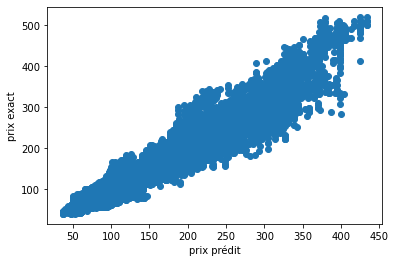

In [47]:
prevB=Bfit.predict(Xr_val)
plt.plot(prevB,Y_val,"o")
plt.xlabel(u"prix prédit")
plt.ylabel(u"prix exact")
plt.show()

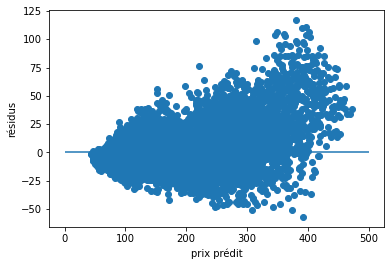

In [48]:
plt.plot(prevOpt,np.ravel(Y_val) - prevOpt,"o")
plt.xlabel(u"prix prédit")
plt.ylabel(u"résidus")
plt.hlines(0,0,500)
plt.show()

## Prédiction sur les données test (à mettre dans un autre fichier qd on passera en .py)

In [27]:
import pandas as pd
import numpy as np
import panel as pn

%matplotlib inline
import matplotlib.pyplot as plt

test = pd.read_csv('./defi-ia-2023/test_set3.csv')
test.head()

,nb_requete,index,order_requests,city,date,language,mobile,avatar_id,hotel_id,stock,group,brand,parking,pool,children_policy
0,1,0,1,vilnius,21,romanian,0,1,161,46,Boss Western,J.Halliday Inn,1,0,0
1,1,1,1,vilnius,21,romanian,0,1,187,32,Accar Hotels,Marcure,1,1,0
2,1,2,1,vilnius,21,romanian,0,1,279,12,Independant,Independant,1,0,0
3,1,3,1,vilnius,21,romanian,0,1,395,10,Accar Hotels,Ibas,0,0,0
4,1,4,1,vilnius,21,romanian,0,1,488,42,Accar Hotels,Safitel,1,1,1


In [50]:
#len(test)

In [51]:
#test.dtypes

In [28]:
#On affecte le bon type aux variables qualitatives
test["city"]=pd.Categorical(test["city"],ordered=False)
test["language"]=pd.Categorical(test["language"],ordered=False)
test["group"]=pd.Categorical(test["group"],ordered=False)
test["brand"]=pd.Categorical(test["brand"],ordered=False)

test["mobile"]=pd.Categorical(test["mobile"],ordered=False)
test["parking"]=pd.Categorical(test["parking"],ordered=False)
test["pool"]=pd.Categorical(test["pool"],ordered=False)
test["children_policy"]=pd.Categorical(test["children_policy"],ordered=False)

test["hotel_id"]=pd.Categorical(test["hotel_id"],ordered=False)
test["avatar_id"]=pd.Categorical(test["avatar_id"],ordered=False)

#test["price"]=pd.DataFrame(test["price"], dtype=float)

#test.dtypes
#test.head()

In [29]:
#avec l'hotel_id
T=test[["city","language","mobile","hotel_id","group","brand","parking","pool","children_policy"]]
#sans l'hotel_id
#T=test[["city","language","mobile","group","brand","parking","pool","children_policy"]]
Tenc=enc.transform(T).toarray()
#Tenc

In [30]:
testDum=pd.DataFrame(Tenc)
#testDum

In [31]:
testQuant = test[["stock","date","nb_requete"]]
#testDum = pd.get_dummies(test[["city","language","mobile","hotel_id","group","brand","parking","pool","children_policy"]])
Xtest = pd.concat([testQuant,testDum],axis=1)
#Xtest.head()

In [32]:
#Xtest.shape

In [33]:
Xr_test = scaler.transform(Xtest) #APPLIQUER LA NORMALISATION

In [34]:
Yprev=rfFit.predict(Xr_test)
#Yprev=rfOpt.predict(Xr_test)
#Yprev=Bfit.predict(Xr_test)

In [35]:
Yprev0=np.around(Yprev, decimals=1)
#Yprev0

In [36]:
len(Yprev0)
Yindice = pd.DataFrame(np.arange(0,len(Yprev0)),columns = ['index'])
#Yindice

In [37]:
Yprice=pd.DataFrame(Yprev0,columns = ['price'])
#Yprice

In [38]:
Ysub=Yindice.join(Yprice, on=None, how='right', lsuffix='', rsuffix='', sort=False)
#Ysub

In [39]:
Ysub.to_csv('./sample_submission12.csv', index= False)

In [ ]:
#len(Ysub)